# Abalone_2
This is the last time I will try to break into data-science, having done so 3 times already within the last 4 years ... achieving nothing... <br>
I am just a simple structured mathematician (master-degree) with some interesst in physics (bachelor) - and maybe to dumb compared to all the geniuses poping up everywhere...<br>
In order for this to have some value, I should write the code myself and not just read, what I have written 2 or 3 years ago. <br>
<br>
So that's why there is this "abalone_2" notebook.

In [24]:
import warnings
warnings.filterwarnings('ignore')

## Data Set Information: ##
<br>
TASK:<br>
Predicting the age of abalone from physical measurements. <br>
<br>
WHY:<br>
The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of <br>
rings through a microscope -- a boring and time-consuming task. Other measurements, which are easier to obtain, are used to predict the age.<br> 
<br> 
WHY DO I WANT TO SOLVE IT:<br>
It can be seen a supervised regression problem. I can try: linear regression, polynomial regression.<br>
It cann also be seen as a classification problem - the number of rings as clases and thus we can use Decision-Trees, Random Forrests, XGBoost, CatBoost, support vector machines.<br>
The regression problem can also be transformed into a classification problem by introducing age-ranges as classes ("binning").<br>
<br> 
ASSUMPTIONS:<br>
Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.<br>
From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200).<br>
<br>
<br>
Attribute Information:<br>
<br>
Given is the attribute name, attribute type, the measurement unit and a brief description. The number of rings is the value to predict: either as a continuous value or as <br>
a classification problem.<br>
<br>
Name / Data Type / Measurement Unit / Description<br>
-----------------------------<br>
Sex / nominal / -- / M, F, and I (infant)<br>
Length / continuous / mm / Longest shell measurement<br>
Diameter / continuous / mm / perpendicular to length<br>
Height / continuous / mm / with meat in shell<br>
Whole weight / continuous / grams / whole abalone<br>
Shucked weight / continuous / grams / weight of meat<br>
Viscera weight / continuous / grams / gut weight (after bleeding)<br>
Shell weight / continuous / grams / after being dried<br>
Rings / integer / -- / +1.5 gives the age in years<br>
<br>
The readme file contains attribute statistics.<br>
<br>


## Data Loading and Splitting

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

columns = ["Sex", "Length", "Diameter", "Height", "Whole", "Shucked", "Viscera", "Shell", "Rings"]
sourcepath = Path(r"Data\abalone.data".replace("\\", "/"))
data = pd.read_csv(sourcepath, names=columns)

data.head()

,Sex,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
data.shape

(4177, 9)

Separate the prediction target from the data:

In [4]:
target = data.iloc[:,-1]
data = data.iloc[:,:-1]
target.shape, data.shape

((4177,), (4177, 8))

In [5]:
# unique values in the target:
print(f"unique target values: {target.unique()}") 
print(f"number of unique target values: {len(target.unique())}")

unique target values: [15  7  9 10  8 20 16 19 14 11 12 18 13  5  4  6 21 17 22  1  3 26 23 29
  2 27 25 24]
number of unique target values: 28


Replace the categorial values in the "Sex" column by one-hot-encoding:

In [6]:
data = pd.get_dummies(data, columns=["Sex"], prefix=['sex_'], dtype=float)
data.head()

,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,sex__F,sex__I,sex__M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0.0,0.0,1.0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0.0,0.0,1.0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1.0,0.0,0.0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0.0,0.0,1.0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0.0,1.0,0.0


Split the data into training and test and validation data:

In [7]:
from sklearn.model_selection import train_test_split

rnd_state = 42

X_train, X_test, y_train, y_test = train_test_split(data.to_numpy(), target.to_numpy(), test_size=0.3, random_state=rnd_state)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2923, 10), (1254, 10), (2923,), (1254,))

In [8]:
# splitting off validation data:

val_size = 0.2

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=val_size, random_state=rnd_state)

X_test.shape, X_val.shape, y_test.shape, y_val.shape

((1003, 10), (251, 10), (1003,), (251,))

## Spot-Shooting Algorithms ##

To hit exactly the right age (number of rings) is difficult for a regression algorithm. To improve, we use range-binning. <br>
Define helper functions, "binIndex" and the "vectorized" version "binIndexVec", to find the bin in which a value lies:

In [9]:
import helperFunctions as hf

(For examples of usage of the helper functions: see the commented code in the helperFunctions.py file)

### Spot-Shooting Classifiers vs Binned Regressors:

We use some classifiers and some regressors without any regularization and hyper-parameter tuning, to get an overview what might work on this dataset. <br>
The classifiers take the number of rings as class-labels. <br>
The regressors take the number of rings simply as numbers. To hit the right number is of course difficult/ improbable and we split the range in smaler intervalls, "bins", counting the prediction as a correct classification, if it is in the right intervall. 

In [ ]:
# without cross-validation:

import helperFunctions as hf

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier, MLPRegressor

# spot shotting classifiers first and binned regressors second:

rings_intervalls = np.arange(0.5, 30, step=1)
accuracies = {}

classifiers = {
    "logistic_reg" : LogisticRegression(solver="sag", max_iter=100, random_state=42, multi_class="multinomial"), # pre-defined parameters to avoid some warnings
    "decision_tree_clf" : DecisionTreeClassifier(),
    "support_vec_clf" : SVC(),
    "random_forrest_clf" : RandomForestClassifier(),
    "gradient_boosting_clf" : GradientBoostingClassifier(),
    "k_NN_clf" : KNeighborsClassifier(),
    "naive_bayes_clf" : GaussianNB(),
    "neural_network_clf" : MLPClassifier()
}

regressors = {
    "linear_reg" : LinearRegression(),
    "support_vec_reg" : SVR(),
    "decision_tree_reg" : DecisionTreeRegressor(),
    "random_forrest_reg" : RandomForestRegressor(),
    "gradient_boosting_reg" : GradientBoostingRegressor(),
    "k_NN_reg" : KNeighborsRegressor(),
    "neural_network_reg" : MLPRegressor()
}

for clf_name, clf_instance in classifiers.items():
    classifier = Pipeline([
        ("ssc", StandardScaler()), # standard scaler because of "sag"-solver
        (clf_name, clf_instance)
    ])

    classifier.fit(X_train, y_train)

    # print prediction :
    y_pred = classifier.predict(X_test)
    accuracies[clf_name] = accuracy_score(y_true=y_test, y_pred=y_pred)


for reg_name, reg_instance in regressors.items():
    regressor = Pipeline([
        ("ssc", StandardScaler()), 
        (reg_name, reg_instance)
    ])

    regressor.fit(X_train, y_train)

    # print prediction accuracy:
    y_pred = regressor.predict(X_test)
    y_pred_discrete = hf.binIndexVec(y_pred, rings_intervalls)

    accuracies[reg_name] = accuracy_score(y_true=y_test, y_pred=y_pred_discrete)

print("--- Accuracies without cross-validation: ---")
for name, acc in accuracies.items():
    print(f"{name} : {acc:.2f}")

#### Results of Spot-Shooting:

| Classifier | Accuracy Class. | Accuracy Reg. | Regressor w. Binning |
| -----------| --------------- | --------------|--------------------- |
| logistic_reg | 0.29 | 0.25|linear_reg|
| decision_tree_clf | 0.20| 0.16|decision_tree_reg|
| support_vec_clf | 0.30 | 0.22|support_vec_reg|
|random_forrest_clf| 0.25| 0.25 |random_forrest_reg|
|gradient_boosting_clf| 0.27| 0.26|gradient_boosting_reg|
|k_NN_clf| 0.23| 0.23 |k_NN_reg|
|Naive_Bayes_clf| 0.10|-|-|
|neural_network_clf| 0.29| 0.23 |neural_network_reg|

#### Findings Classifier vs. Binned Regressor:
We see that the classifiers have better accuracy than the binned regressors:

In [19]:
acc_values = np.array(list(accuracies.values()))
mean_acc_clf = np.delete(acc_values[0:8],6).mean() # removed the naive_base_cl value
mean_acc_reg = acc_values[8:].mean()
print(f"mean accuracies of classifiers {mean_acc_clf:.3f}")
print(f"mean accuracies of binned regressors {mean_acc_reg:.3f}")
print(f"Difference in accuracy: {mean_acc_clf - mean_acc_reg:.3f}")


mean accuracies of classifiers 0.262
mean accuracies of binned regressors 0.228
Difference in accuracy: 0.034


output from last cell: <br>
mean accuracies of classifiers 0.262 <br>
mean accuracies of binned regressors 0.228 <br>
Difference in accuracy: 0.034 <br>

Nevertheless binned regressors like linear, random-forrest and gradient-bosting are in the same ballpark as the classifiers with about 25% accuracy.<br>
It could be worth while to investigate, what can be done with them by optimizing and ensembling - where an ensemble of a mix of classifiers and regressors could<br>
be especially interessting.<br>


### Spot-Shooting Classifiers with Cross-Validation

Since the classifiers seem to work better on this dataset than the binned regressors, we continue with the classifiers only. <br> 
In order to get a more reliable estimation for the accuracy of a model we use cross-validation.

In [ ]:
# with crossvalidation

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

accuracies = {}
validation_folds = 10

print(f"--- Using Classifiers with {validation_folds}-fold Cross-Validation ---")

classifiers = {
    "logistic_reg" : LogisticRegression(solver="sag", max_iter=100, random_state=42, multi_class="multinomial"), # pre-defined parameters to avoid some warnings
    "decision_tree_clf" : DecisionTreeClassifier(),
    "support_vec_clf" : SVC(),
    "random_forrest_clf" : RandomForestClassifier(),
    "gradient_boosting_clf" : GradientBoostingClassifier(),
    "k_NN_clf" : KNeighborsClassifier(),
    "naive_bayes_clf" : GaussianNB(),
    "neural_network_clf" : MLPClassifier()
}

for clf_name, clf_instance in classifiers.items():
    classifier = Pipeline([
        ("ssc", StandardScaler()), # standard scaler because of "sag"-solver
        (clf_name, clf_instance)
    ])

    accuracy = cross_val_score(classifier, X_train, y_train, scoring= "accuracy", cv = validation_folds)

    accuracies[clf_name] = accuracy.mean()

print("--- Accuracies with cross-validation: ---")
for name, acc in accuracies.items():
    print(f"{name} : {acc:.2f}")

#### Results Spot-Shooting with Crossvalidation:

-- we have a bunch of non-convergence warnings, that still have to be understood -- <br>

--- Accuracies with cross-validation: --- <br>
logistic_reg : 0.26 <br>
decision_tree_clf : 0.19 <br>
support_vec_clf : 0.26 <br>
random_forrest_clf : 0.24 <br>
gradient_boosting_clf : 0.25 <br>
k_NN_clf : 0.22 <br>
naive_bayes_clf : 0.10 <br>
neural_network_clf : 0.24 <br>

#### ToDos: 
+ find/ define/ use some statistical tests to assess significance of differences in results

### Sum-Up Spot Shoting: 

#### Accuracies of different models without and with cross-validation:
| Model                     | Accuracy wo CV | Accuracy w CV |
| ------------------------- | -------------- | ------------- |
| support_vec_classifier    |           0.30 |          0.26 |
| logistic_reg              |           0.29 |          0.26 |
| neural_network_clf        |           0.29 |          0.24 |
| gradient_boosting_clf     |           0.27 |          0.25 |
| random_forrest_clf        |           0.25 |          0.24 |
| k_NN_clf                  |           0.23 |          0.22 |
| decision_tree_clf         |           0.20 |          0.19 |
| Naive_Bayes_clf           |           0.10 |          0.10 |



When I tried to use the binned regressors I got non-convergence errors for all of them - since we do not include the binning in the pipeline, they simply do not hit the targets exactly. <br>
All accuracies decreased by 1 or 2 percent when doing cross-validation. This is expected because every single model can be expected to accquire some form of overfitting, which is averaged out by cross-validation<br>
<br>

#### The top algorithms by accuracy are:
| Model                     | Accuracy no CV | Accuracy w CV |
| ------------------------- | -------------- | ------------- |
| support_vec_classifier    |           0.30 |          0.26 |
| logistic_reg              |           0.29 |          0.26 |
| neural_network_clf        |           0.29 |          0.24 |
| gradient_boosting_clf     |           0.27 |          0.25 |

<br>
Other classifiers not yet been tested could be: XGBoost, Polynomial-Regression classifier.

## More on Correlation and Linearity... ##

### Correlation and Linearity of Models ###

Because of the relatively strong performance of the linear regression model, it might be worth while to look at the correlation matrix of the data. High correlation of variables means an almost linear relationship, which could give us a hint, in how far a linear model can be usefull.

#### Plot the Correlation Matrix for the Data

<AxesSubplot:>

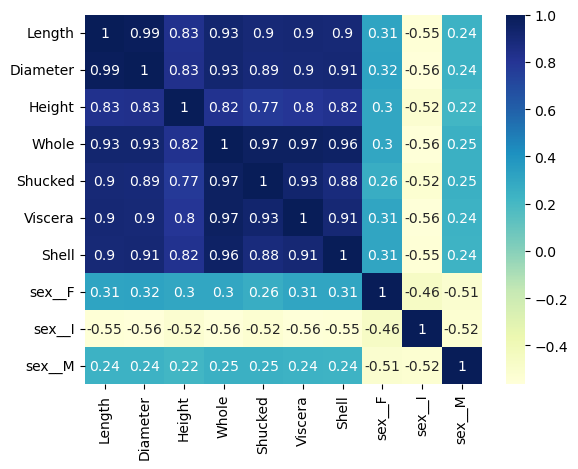

In [16]:
import seaborn as sns
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)

All columns of the data are highly correlated with each other except for the column "Sex". <br> 
Obviously they are all connected to a more general variable we could call "size" (assuming that there are some more or less constant <br>
proportions for an abalone...): <br>
<br>
*This connection to some sort of "size" could mean, that we should try polynomial-regression* (seeing "size" as volume or surface-area) or we could try to reduce the <br> 
number of variables: maybe there is not much to discover from anything more but one of them, say "Length". <br>

### Let's look at the correlation of each feature with the target:

add the target to the data (again):

In [17]:
data_target = pd.concat([data, target], axis=1)

calculate and draw the correlation matrix:

<AxesSubplot:>

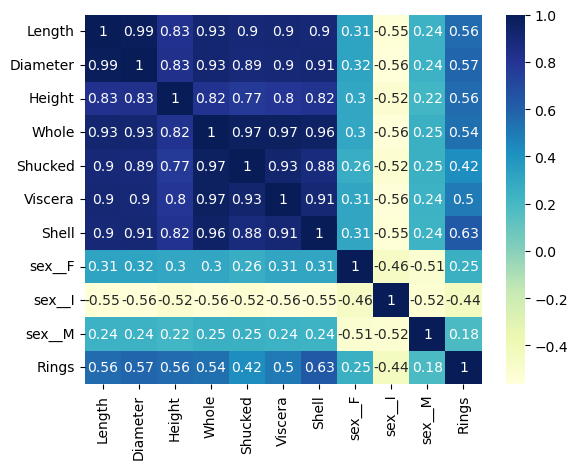

In [18]:
sns.heatmap(data_target.corr(), cmap="YlGnBu", annot=True)

The parameters "Length", "Diameter", "Height", "Whole" and "Shell" have the strongest correlation with the target variable "rings" - albeit considerably lower than with eachother. <br>
We can try to see how much can be predicted from only these variables with highest correlation. We start with only one, the most correlated one, "Shell", and ta

Length, Diameter, Height, Whole, Shell , [0, 1, 2, 3, 6]

In [19]:
ar = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
ar[:, [1,3]]

array([[ 2,  4],
       [ 6,  8],
       [10, 12]])

### Predictions With Only One Feature ###

We have high correlations of the age/rings with "shell", "diameter", "hight", "length". <br>
How about just using the "shell" as the single feature to predict age?

In [20]:
data.head()

,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,sex__F,sex__I,sex__M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0.0,0.0,1.0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0.0,0.0,1.0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1.0,0.0,0.0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0.0,0.0,1.0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0.0,1.0,0.0


In [21]:
from sklearn.model_selection import train_test_split

rnd_state = 42

data_shell = data["Shell"].to_numpy()

X_train_shell, X_test_shell, y_train_shell, y_test_shell = train_test_split(data_shell, target.to_numpy(), test_size=0.3, random_state=rnd_state)
X_train_shell = np.expand_dims(X_train_shell, axis=1)
X_test_shell = np.expand_dims(X_test_shell, axis=1)

X_train_shell.shape, X_test_shell.shape, y_train_shell.shape, y_test_shell.shape

((2923, 1), (1254, 1), (2923,), (1254,))

In [22]:
# without cross-validation:

# TRAINING ON ONLY ONE FEATURE OF THE DATA.

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score


rings_intervalls = np.arange(0.5, 30, step=1)
accuracies = {}

classifiers = {
    "logistic_reg" : LogisticRegression(solver="sag", max_iter=100, random_state=42, multi_class="multinomial"),
    "decision_tree_clf" : DecisionTreeClassifier(),
    "support_vec_clf" : SVC(),
    "random_forrest_clf" : RandomForestClassifier(),
    "gradient_boosting_clf" : GradientBoostingClassifier(),
    "k_NN_clf" : KNeighborsClassifier(),
    "naive_bayes_clf" : GaussianNB(),
    "neural_network_clf" : MLPClassifier()
}

regressors = {
    "linear_reg" : LinearRegression(),
    "support_vec_reg" : SVR(),
    "decision_tree_reg" : DecisionTreeRegressor(),
    "random_forrest_reg" : RandomForestRegressor(),
    "gradient_boosting_reg" : GradientBoostingRegressor(),
    "k_NN_reg" : KNeighborsRegressor(),
    "neural_network_reg" : MLPRegressor()
}

accuracies = hf.spot_shot_classifiers(classifiers, X_train_shell, X_test_shell, y_train_shell, y_test_shell)
accuracies = { **accuracies, **hf.spot_shot_regressors(regressors, rings_intervalls, X_train_shell, X_test_shell, y_train_shell, y_test_shell)}

print("--- Accuracies without cross-validation: ---")
for name, acc in accuracies.items():
    print(f"{name} : {acc:.2f}")

--- Accuracies without cross-validation: ---
logistic_reg : 0.26
decision_tree_clf : 0.22
support_vec_clf : 0.29
random_forrest_clf : 0.21
gradient_boosting_clf : 0.24
k_NN_clf : 0.22
naive_bayes_clf : 0.27
neural_network_clf : 0.28
linear_reg : 0.26
support_vec_reg : 0.26
decision_tree_reg : 0.18
random_forrest_reg : 0.21
gradient_boosting_reg : 0.25
k_NN_reg : 0.22
neural_network_reg : 0.26


##### Accuracies of predicitons based on only one feature (without cross-validation):

| Model                     | Accuracy All Features  | Accuracy "Shell" |Accuracy Difference |
| ------------------------- | ---------------------- | ---------------- | ------------------ |
| support_vec_classifier    |                   0.30 |             0.29 |              -0.01 |
| logistic_reg              |                   0.29 |             0.26 |              -0.03 |
| neural_network_clf        |                   0.29 |             0.29 |               0.00 |
| gradient_boosting_clf     |                   0.27 |             0.24 |              -0.03 |
| gradient_boosting_reg     |                   0.26 |             0.25 |              -0.01 |
| linear_reg                |                   0.25 |             0.25 |               0.00 |
| random_forrest_reg        |                   0.25 |             0.21 |              -0.04 |
| random_forrest_clf        |                   0.25 |             0.22 |              -0.03 |
| k_NN_clf                  |                   0.23 |             0.22 |              -0.01 |
| k_NN_reg                  |                   0.23 |             0.22 |              -0.01 |
| neural_network_reg        |                   0.23 |             0.26 |              +0.03 |
| support_vec_reg           |                   0.22 |             0.26 |              +0.04 |
| decision_tree_clf         |                   0.20 |             0.22 |              +0.02 |
| decision_tree_reg         |                   0.16 |             0.18 |              +0.02 |
| Naive_Bayes_clf           |                   0.10 |             0.27 |              +0.17 |

#### Findings:
The loss in accuracy is not overwhelming for any of the models - maybe except for the random-forrest regressor: 4% total or some 18%-points. <br> 
How a decision-tree model with only one feature works is unclear to me. It is interessting though, that the Naive-Bayes Classifier on one feature <br>
is as good as a gradient-boosting-classifier on all features and only 3%, i.e. 10%-points worse than the best support-vector-classifier on all features. <br>
<br>
**Nonetheless: these are only values from one-time training, i.e. their stability/ significance is completely unclear.** <br>
 <br>
**We need statistical checks, otherwise this is just reading tea leaves...**


#### ToDos: ####
1. A feature-selection algorithm like "Boruta" (usefull for this case? most/any case?) might be used to try to find the most informative features
2. esthablish statistical significance tests for the results!

## Improving Results ##

### Further possible improvements: ###

1. use PolynomialFeatures: <br>
1.1 use features with high correlation to target <br>
1.2 use features to test the idea of "size" being a predictor, i.e. Length, Diameter, Height <br>
2. use regularization: non-negative least squares, ridge, lasso, elastic-net
3. use Bayesian Regression (to chose a different type of regression from scikit) ?
https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression

### Augmenting the Data-Set by Polynomial Features

In [23]:
#X_train_poly = X_train[:, [0, 1, 2, 3, 6]] #Length, Diameter, Height, Whole, Shell : "5 Selec"
X_train_poly = X_train[:, [0, 1, 2]] #Length, Diameter, Height : "3 Selec"
X_train_poly.shape

(2923, 3)

In [24]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3, interaction_only=True, )

X_train_poly = poly.fit_transform(X_train_poly)


In [25]:
# with crossvalidation

import helperFunctions as hf

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score

# spot shotting classifiers first and binned regressors second:

accuracies = {}

classifiers = {
    "logistic_reg" : LogisticRegression(solver="sag", max_iter=100, random_state=42, multi_class="multinomial"),
    "decision_tree_clf" : DecisionTreeClassifier(),
    "support_vec_clf" : SVC(),
    "random_forrest_clf" : RandomForestClassifier(),
    "gradient_boosting_clf" : GradientBoostingClassifier(),
    "k_NN_clf" : KNeighborsClassifier(),
    "naive_bayes_clf" : GaussianNB(),
    "neural_network_clf" : MLPClassifier()
}

for clf_name, clf_instance in classifiers.items():
    classifier = Pipeline([
        ("ssc", StandardScaler()), # standard scaler because of "sag"-solver
        (clf_name, clf_instance)
    ])

    accuracy = cross_val_score(classifier, X_train_poly, y_train, scoring= "accuracy", cv = 10)

    accuracies[clf_name] = accuracy.mean()

print("--- Polynomial Features: Accuracies with Cross-Validation: ---")
for name, acc in accuracies.items():
    print(f"{name} : {acc:.2f}")


--- Using Classifiers and binned Regressors with Cross-Validation ---


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\H

--- Accuracies with cross-validation: ---
logistic_reg : 0.25
decision_tree_clf : 0.17
support_vec_clf : 0.26
random_forrest_clf : 0.19
gradient_boosting_clf : 0.20
k_NN_clf : 0.21
naive_bayes_clf : 0.21
neural_network_clf : 0.26


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


##### Accuracies of predicitons based on all features, only one feature and a selection of features (using polynomial features):

| Model                     | Accuracy All | Accuracy "Shell" |Accuracy Diffs | Accuracy "5 Selec" |Accuracy Diffs |Accuracy "3 Selec" |Accuracy Diffs |
| ------------------------- | ------------ | ---------------- | ------------- | ------------------ | ------------- | ----------------- | ------------- |
| support_vec_classifier    |         0.30 |             0.29 |         -0.01 |               0.26 |         -0.04 |              0.26 |         -0.04 |
| logistic_reg              |         0.29 |             0.26 |         -0.03 |               0.26 |         -0.04 |              0.25 |         -0.04 |
| neural_network_clf        |         0.29 |             0.29 |          0.00 |               0.27 |         -0.02 |              0.25 |         -0.04 |
| gradient_boosting_clf     |         0.27 |             0.24 |         -0.03 |               0.23 |         -0.04 |              0.20 |         -0.07 |
| random_forrest_clf        |         0.25 |             0.22 |         -0.03 |               0.24 |         -0.01 |              0.19 |         -0.06 |
| k_NN_clf                  |         0.23 |             0.22 |         -0.01 |               0.22 |         -0.01 |              0.21 |         -0.02 |
| decision_tree_clf         |         0.20 |             0.22 |         +0.02 |               0.19 |         -0.01 |              0.17 |         -0.03 |
| Naive_Bayes_clf           |         0.10 |             0.27 |         +0.17 |               0.14 |         +0.04 |              0.21 |          0.11 |



Findings: <br>
Polynomial features proved to be of no use - all the best classifiers performed worse than on the original features and worse than on the single feature <br> "shell" - that was chosen because of it's high correlation coefficient with the target ("rings"). The idea formulated before, that something like "size" could be a good predictor - i.e. stuff like width * length, windth * heigth * length, i.e. polynomials of 2nd and 3rd degree - is obviously wrong: the values in the column "Accuracy "3 Selec" are proof of this.

### Support Vector Regression ###

### Support Vector Regression with different Kernels ###

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


pipe_svc = Pipeline([
    ("ssc", StandardScaler()),
    ("svc", SVC())
])

params = {
    "svc__C" : [900],
    "svc__degree" : [2, 3, 4],
    "svc__kernel" : ['poly'],
}

svc_clf = GridSearchCV(pipe_svc, params, n_jobs=-1, cv=10, scoring="accuracy")

svc_clf.fit(X_train, y_train)

print(f"Best estimator: {svc_clf.best_estimator_}")
print(f"Best parameter training: {svc_clf.best_params_}")
print(f"Mean cross-validated score of the best_estimator: {svc_clf.best_score_ :.2f}")
print(f"Score on testset: {svc_clf.score(X_test, y_test):.3f}")


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Best estimator: Pipeline(steps=[('ssc', StandardScaler()), ('svc', SVC(C=900, kernel='poly'))])
Best parameter training: {'svc__C': 900, 'svc__degree': 3, 'svc__kernel': 'poly'}
Mean cross-validated score of the best_estimator: 0.27
Score on testset: 0.266


Findings: <br>
The C parameter (inverse regularizing - the larger C the less regularization) of 900 was found from [1, 100, 1000, 2000] and then [800, 850, 900, 950]. <br>
Searching for optimal gamma-value with [0.001, 1, 100] was aborted because of run-times over 20 minutes without result. Even trying [1, 100] and finally [1] <br> resulted in long runtimes (over 20 minutes) which I don't understand. So I leave it to the default. <br>
The best result with degree = 3 is: <br>
Best parameter training: {'svc__C': 900, 'svc__kernel': 'poly'} <br>
Mean cross-validated score of the best_estimator: 0.27 <br>
Score on testset: 0.266 <br>
runtime: 4m 6.3s <br>
<br>
Trying out: <br>
params = { <br>
    "svc__C" : [900], <br>
    "svc__degree" : [2, 3, 4], <br>
    "svc__kernel" : ['poly'], <br>
} <br>
<br>
resulted in: <br>
<br>
Best parameter training: {'svc__C': 900, 'svc__degree': 3, 'svc__kernel': 'poly'} <br>
Mean cross-validated score of the best_estimator: 0.27 <br>
Score on testset: 0.266 <br>
<br>
So probably an accuray of 27% is the best we can get from the SVC.


Supportvector Regressor based on a PCA (for what?) of the data:

In [43]:
# if kernel=None then by default kernel="rbf" is used (see: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)
# We try polynomial features.

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC


pipe_svc = Pipeline([
    ("pca", PCA()),
    ("ssc", StandardScaler()),
    ("svc", SVC())

])

params = {
    "pca__n_components" : np.arange(1,11),
    "svc__kernel" : ['sigmoid', 'poly', 'rbf'],
    #"svr__degree" : np.arange(2,6),
}

svc_clf = GridSearchCV(pipe_svc, params, n_jobs=-1, cv=10, scoring="accuracy")

svc_clf.fit(X_train, y_train)

print(f"Best estimator: {svc_clf.best_estimator_}")
print(f"Best parameter training: {svc_clf.best_params_}")
print(f"Mean cross-validated score of the best_estimator: {svc_clf.best_score_ :.2f}")
print(f"Score on testset: {svc_clf.score(X_test, y_test):.3f}")


c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Best estimator: Pipeline(steps=[('pca', PCA(n_components=7)), ('ssc', StandardScaler()),
                ('svc', SVC())])
Best parameter training: {'pca__n_components': 7, 'svc__kernel': 'rbf'}
Mean cross-validated score of the best_estimator: 0.27
Score on testset: 0.304


#### Results - SVR w Kernels:
Best estimator: Pipeline(steps=[('pca', PCA(n_components=8)), ('ssc', StandardScaler()), ('svr', SVR())]) <br>
Best parameter training: {'pca__n_components': 8, 'svr__kernel': 'rbf'} <br>
Score on testset: 0.562 <br>
Accuracy: 0.23 <br>

### Ensembling Lin-Reg and SVR ###

#### Bagging Linear-Regression ####

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor


pipe_lin_reg = Pipeline([
    ("pca", PCA(n_components=8)),
    ("ssc", StandardScaler()),
    ("kmeans", KMeans()),
    ("linear_reg", LinearRegression())
])

bag_lin_reg = BaggingRegressor(base_estimator=pipe_lin_reg, n_jobs=-1, n_estimators=10)
bag_lin_reg.fit(X_train, y_train)

print(f"Test score bag-linear-regressor: {bag_lin_reg.score(X_test, y_test):.3f}")

age_bins = np.arange(0.5, 30, step=1)
y_pred_discrete = binIndexVec(bag_lin_reg.predict(X_test), bin_edges=age_bins)
print(f"Accuracy: {accuracy_score(y_test, y_pred_discrete):.2f}")


# Result:
# Test score bag-lin-regressor: 0.557
# similar results for n_estimators = 50, 100

c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Test score bag-linear-regressor: 0.546
Accuracy: 0.26


#### Results - Bagging Linear Regressor:
time: 1,9s <br>
Test score bag-linear-regressor: 0.546 <br>
Accuracy: 0.26 <br>

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    "pca__n_components" : np.arange(10),
    "kmeans__n_clusters" : np.arange(10, 150, 10),
    "kmeans__max_iter" : np.arange(500, 800, 100),
}

#clf = GridSearchCV(pipe_lin_reg, params, n_jobs=-1, cv=10)

#clf.fit(X_train, y_train)

print(f"Best parameters: {clf.best_params_}")
print(f"Best training-score: {clf.best_score_:.3f}")
print(f"Score on test data: {clf.score(X_test, y_test):.3f}")

Best parameters: {'kmeans__max_iter': 700, 'kmeans__n_clusters': 190}
Best training-score: 0.433
Score on test data: 0.459


#### Bagging Support Vector Regression ####

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor


pipe_svr = Pipeline([
    ("pca", PCA(n_components=8)),
    ("ssc", StandardScaler()),
    ("svr", SVR())
])

bag_svr = BaggingRegressor(base_estimator=pipe_svr, n_jobs=-1)
bag_svr.fit(X_train, y_train)

print(f"Test score bag-sv-regressor: {bag_svr.score(X_test, y_test):.3f}")

age_bins = np.arange(0.5, 30, step=1)
y_pred_discrete = binIndexVec(bag_svr.predict(X_test), bin_edges=age_bins)
print(f"Accuracy: {accuracy_score(y_test, y_pred_discrete):.2f}")

# Result:
# 1.
# n_estimators = 10
# Test score bag-sv-regressor: 0.555
# similar results with n_estimators = 30, 50, 100 

c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Test score bag-sv-regressor: 0.561
Accuracy: 0.22


#### Results - Bagging SVR:
time: 2,2s <br>
Test score bag-sv-regressor: 0.561 <br>
Accuracy: 0.22 <br>

### Ensembling by Voting: Lin-Reg and SVR ###

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor

pipe_lin_reg = Pipeline([
    ("pca", PCA(n_components=8)),
    ("ssc", StandardScaler()),
    ("kmeans", KMeans(max_iter=600, n_clusters= 60)),
    ("log_reg", LinearRegression())
])

pipe_svr = Pipeline([
    ("pca", PCA(n_components=8)),
    ("ssc", StandardScaler()),
    ("svr", SVR())
])

vr_reg = VotingRegressor([("lin_reg", pipe_lin_reg), ("svr", pipe_svr)], n_jobs=-1)
vr_reg.fit(X_train, y_train)
print(f"Voting-Regressor score: {vr_reg.score(X_test, y_test):.3f}")
print(f"Voting estimators: {vr_reg.estimators_}")

age_bins = np.arange(0.5, 30, step=1)
y_pred_discrete = binIndexVec(vr_reg.predict(X_test), bin_edges=age_bins)
print(f"Accuracy: {accuracy_score(y_test, y_pred_discrete):.2f}")

# Result:
# Voting-Regressor score: 0.578
# Voting estimators: [Pipeline(steps=[('pca', PCA(n_components=8)), ('ssc', StandardScaler()),
#                ('kmeans', KMeans(max_iter=600, n_clusters=60)),
#                ('log_reg', LinearRegression())]), Pipeline(steps=[('pca', PCA(n_components=8)), ('ssc', StandardScaler()),
#                ('svr', SVR())])]

Voting-Regressor score: 0.575
Voting estimators: [Pipeline(steps=[('pca', PCA(n_components=8)), ('ssc', StandardScaler()),
                ('kmeans', KMeans(max_iter=600, n_clusters=60)),
                ('log_reg', LinearRegression())]), Pipeline(steps=[('pca', PCA(n_components=8)), ('ssc', StandardScaler()),
                ('svr', SVR())])]
Accuracy: 0.23


#### Result - Voting Regressor of Linear Regressor and SVR:
Voting-Regressor score: 0.575 <br>
Voting estimators: [Pipeline(steps=[('pca', PCA(n_components=8)), ('ssc', StandardScaler()), <br>
('kmeans', KMeans(max_iter=600, n_clusters=60)), <br>
('kmeans', KMeans(max_iter=600, n_clusters=60)), <br> 
('log_reg', LinearRegression())]),  <br>
Pipeline(steps=[('pca', PCA(n_components=8)), ('ssc', StandardScaler()), ('svr', SVR())])]<br>
Accuracy: 0.23 <br>

### Sum-up Voting Regressor ###
The voting-regressor consisting of a lin-reg and an svr does not do better than the lin-reg allone.
<br>
One reason might be, that both are doing well/not-so-well on the same sets of datapoints such that there is no gain in voting. <br> 
<br>
Maybe we could improve by adding one of the weaker models to the ensemble (LogisticRegression, KNeighbourRegression, DecisionTreeRegression)

## Save Model / Load Model ##

In [ ]:
# save the model to disk:
import pickle

filename = 'votingRegressor.sav'
pickle.dump(vr_reg, open(filename, 'wb'))

In [ ]:
# load the model from disk: 
import pickle

loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(f"{result:.3f}")

0.576


# Neural Net Classifier #

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

columns = ["Sex", "Length", "Diameter", "Height", "Whole", "Shucked", "Viscera", "Shell", "Rings"]
sourcepath = Path(r"Data\abalone.data".replace("\\", "/"))
data = pd.read_csv(sourcepath, names=columns)
# split off targets:
targets = data.iloc[:,-1]
data = data.iloc[:,:-1]

# one-hot-encode Sex:
data = pd.get_dummies(data)

# train-test-split:
from sklearn.model_selection import train_test_split

random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(data.to_numpy(), targets.to_numpy(), test_size= 0.2, random_state=random_seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, type(X_train)

((3341, 10), (836, 10), (3341,), (836,), numpy.ndarray)

In [ ]:
# Torch data-set definition:

import torch
from torch import nn
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split

import os
import pandas as pd

class AbaloneDataset(Dataset):
    def __init__(self, data, targets, transform=None, target_transform=None):
        self.y = targets
        self.X = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        data_record = self.X[idx,:]
        target = self.y[idx]
        if self.transform:
            data_record = self.transform(data_record)
        if self.target_transform:
            target = self.target_transform(target)
        return torch.tensor(data_record, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

train = AbaloneDataset(X_train, y_train)
test = AbaloneDataset(X_test, y_test)
train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)


In [ ]:
# Model definition:

class NeuralFC(nn.Module):
    def __init__(self, input_dim) -> None:
        super(NeuralFC, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self,x):
        age = self.linear_relu_stack(x)
        return age


in_dim = len(data.iloc[0].to_numpy())
model = NeuralFC(in_dim)
loss_fct = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters())


In [ ]:
# training the model:

epochs = range(100)

for epoch in epochs:
    loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(inputs)
        loss = loss_fct(y_pred, targets)
        loss.backward()
        optimizer.step()
    if epoch == 1 or epoch % 10 == 0:
            print(f"epoch: {epoch} - training-loss: {loss:.2f}")

epoch: 0 - training-loss: 17.64
epoch: 1 - training-loss: 8.23
epoch: 10 - training-loss: 13.11
epoch: 20 - training-loss: 15.75
epoch: 30 - training-loss: 3.01
epoch: 40 - training-loss: 13.30
epoch: 50 - training-loss: 13.15
epoch: 60 - training-loss: 6.39
epoch: 70 - training-loss: 7.73
epoch: 80 - training-loss: 11.79
epoch: 90 - training-loss: 6.45


In [ ]:
# testing the models prediction accuracy on test-set:

def MeanModelPredictionAccuracy(nmodel, test_loader, accepted_proximity= None):
        predictions = []
        actuals = []
        if(not accepted_proximity):
                accepted_proximity = 0

        for i, (inputs, targets) in enumerate(test_loader):
                y_pred = nmodel(inputs)
                y_pred = y_pred.detach().numpy()
                y_pred = y_pred.round()
                predictions.append(y_pred)
                actuals.append(targets.numpy())

        predictions = np.concatenate(predictions)
        actuals = np.concatenate(actuals)
        hits = np.array([abs(p-a) <= accepted_proximity for p,a in zip(predictions, actuals)])
        return hits.mean()

In [ ]:
MeanModelPredictionAccuracy(model, train_loader, accepted_proximity=2.5) 
# the intervall of proximity is 2 times the accepted_proximity, i.e. we have a tollerance of 5 rings, when accepted_proximity=2.5

0.5459443280454953

In [ ]:
MeanModelPredictionAccuracy(model, train_loader, accepted_proximity=0.5) 

0.11792876384316073